# Imports


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
import os # Added for saving segments

D:\Applications\Anaconda\envs\tensorflowgpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# Custom DFS-based Connected Components Algorithm

In [2]:
def custom_connected_components_dfs(binary_image_input, connectivity=4):
    """
    Performs Connected Components Analysis (CCA) using Depth-First Search (DFS).
    This function identifies and labels distinct foreground regions (connected pixels)
    in a binary image.

    Args:
        binary_image_input (np.ndarray): A 2D binary image.
                                         Foreground pixels (regions to be analyzed) should be 255.
                                         Background pixels (edges or empty space) should be 0.
        connectivity (int): Defines how pixels are considered connected.
                            4: Only horizontal and vertical neighbors.
                            8: Horizontal, vertical, and diagonal neighbors.

    Returns:
        tuple: Contains detailed information about each detected connected component.
               - total_components_found (int): The total count of unique labels found,
                                               including label 0 for the background.
               - component_labels_map (np.ndarray): A 2D array of the same shape as
                                                    binary_image_input, where each pixel
                                                    contains the integer label of the
                                                    component it belongs to. Background is 0.
               - component_stats (np.ndarray): An N x 5 numpy array, where N is the
                                               total_components_found. Each row corresponds
                                               to a component (indexed by its label) and contains:
                                               [leftmost_x, topmost_y, width, height, area_in_pixels].
                                               This information can be used for bounding boxes,
                                               filtering by size, etc.
               - component_centroids (np.ndarray): An N x 2 numpy array. Each row contains
                                                  the (x, y) centroid coordinates (average
                                                  position) of the corresponding component.
                                                  Useful for locating the center of objects.
    """
    image_height, image_width = binary_image_input.shape

    # Initialize an array to store the label for each pixel. 0 means unlabeled or background.
    component_labels_map = np.zeros_like(binary_image_input, dtype=np.int32)

    current_label_id = 0 # Starts from 1 for actual components (0 is reserved for background)

    # Lists to collect statistics and centroids for all components
    all_component_stats = []
    all_component_centroids = []

    # Define neighbor offsets based on connectivity (dr=delta row, dc=delta col)
    if connectivity == 4:
        # 4-directional: Right, Down, Left, Up
        neighbor_offsets = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    elif connectivity == 8:
        # 8-directional: Horizontal, Vertical, and Diagonals
        neighbor_offsets = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    else:
        raise ValueError("Connectivity must be 4 or 8.")

    # Iterate through every pixel in the image
    for row in range(image_height):
        for col in range(image_width):
            # If a pixel is foreground (255) and hasn't been labeled yet (0),
            # it's the start of a new connected component.
            if binary_image_input[row, col] == 255 and component_labels_map[row, col] == 0:
                current_label_id += 1 # Assign a new unique label ID

                # Use a deque (double-ended queue) for efficient DFS.
                # It stores pixels to visit within the current component.
                stack = deque([(row, col)])
                component_labels_map[row, col] = current_label_id # Label the starting pixel

                # Lists to collect all pixels (rows and columns) belonging to the current component
                # This is used to calculate stats like bounding box and area later.
                pixels_in_current_component_rows = []
                pixels_in_current_component_cols = []

                # Perform DFS to find all connected pixels for the current component
                while stack:
                    current_pixel_row, current_pixel_col = stack.pop()

                    # Add current pixel to the list for stats calculation
                    pixels_in_current_component_rows.append(current_pixel_row)
                    pixels_in_current_component_cols.append(current_pixel_col)

                    # Check all neighbors
                    for dr, dc in neighbor_offsets:
                        neighbor_row, neighbor_col = current_pixel_row + dr, current_pixel_col + dc

                        # Check if neighbor is within image bounds, is a foreground pixel (255),
                        # and has not been labeled yet (0).
                        if (0 <= neighbor_row < image_height and
                            0 <= neighbor_col < image_width and
                            binary_image_input[neighbor_row, neighbor_col] == 255 and
                            component_labels_map[neighbor_row, neighbor_col] == 0):

                            component_labels_map[neighbor_row, neighbor_col] = current_label_id # Label the neighbor
                            stack.append((neighbor_row, neighbor_col)) # Add neighbor to stack for further exploration

                # --- Calculate Statistics for the current component ---
                if pixels_in_current_component_rows: # Ensure the component actually has pixels
                    # Bounding Box (leftmost_x, topmost_y, width, height)
                    min_row, max_row = min(pixels_in_current_component_rows), max(pixels_in_current_component_rows)
                    min_col, max_col = min(pixels_in_current_component_cols), max(pixels_in_current_component_cols)

                    leftmost_x = min_col
                    topmost_y = min_row
                    component_width = max_col - min_col + 1
                    component_height = max_row - min_row + 1

                    # Area (number of pixels in the component)
                    component_area = len(pixels_in_current_component_rows)

                    # Centroid (average x and y coordinates)
                    centroid_x = np.mean(pixels_in_current_component_cols)
                    centroid_y = np.mean(pixels_in_current_component_rows)

                    # Store stats in a format consistent with OpenCV's connectedComponentsWithStats
                    all_component_stats.append([leftmost_x, topmost_y, component_width, component_height, component_area])
                    all_component_centroids.append([centroid_x, centroid_y])
                else:
                    # This case should ideally not be hit if a pixel (255) triggered the DFS
                    all_component_stats.append([0, 0, 0, 0, 0])
                    all_component_centroids.append([0, 0])

    # Insert dummy stats/centroid for background label 0 at the beginning of the lists
    all_component_stats.insert(0, [0, 0, 0, 0, 0])
    all_component_centroids.insert(0, [0, 0])

    # The total number of unique labels found (including background label 0)
    total_components_found = current_label_id + 1

    return total_components_found, component_labels_map, np.array(all_component_stats, dtype=np.int32), np.array(all_component_centroids, dtype=np.float32)

# Custom Loss Function for Model Loading

In [3]:
# regular binary cross entropy didn't work very well, so we use a weighted binary crossentropy
# we punish false negatives more than false positives

def weighted_binary_crossentropy(zero_weight, one_weight):
    
    def loss(y_true, y_pred):
        
        # true labels were initially in integer datatype, so cast to float32 to work with predicted labels
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred) # calculate binary cross entropy (for each element)

        '''
            now, we want to assign a weight for each value from binary cross entropy
            here, y_true and y_pred are a 50x50x1 matrix,
            and weight for y_pred[i][j] = weight that should be multiplied with y_pred when y_true is = 1 if y_true[i][j] = 1
            similarly, weight for y_pred[i][j] = weight that should be multiplied with y_pred when y_true is = 0 if y_true[i][j] = 0
            so, the best way to do this is, weights[i][j] = y_true * weight for when y_true is one + (1 - y_true) * weight for when y_true is 0
            since we know y_true[i][j] can either be 0 or 1 only
            if y_true is 1, the second term goes to 0, and if y_true is 0, the first term goes to zero
            so thats how we calculate the weight matrix
        '''
        weights = y_true * one_weight + (1 - y_true) * zero_weight
        return tf.reduce_mean(bce * weights) # now perform element wise multiplication, and return mean of the final matrix
        
    return loss

# Dataset and Model Loading

In [4]:
'''
So the idea is to get the edge detection labels from the model using the fourier image and use the label to segment 
the corresponding colour image
'''

BATCH_SIZE = 1

# load fourier image dataset
fourier_dataset_path = r"D:\Education\Code Bases\Python\Metal Analysis\metal_edge_dataset"
fourier_dataset = tf.data.Dataset.load(fourier_dataset_path)
fourier_dataset = fourier_dataset.batch(BATCH_SIZE) # this dataset isn't batched for some reason so we batch that shit

colour_dataset_path = r"D:\Education\Code Bases\Python\Metal Analysis\colour_images_dataset"
colour_dataset = tf.data.Dataset.load(colour_dataset_path) # this dataset is already batched

In [5]:
# --- Load Pre-trained Model ---
# specify the path to your saved Keras model file
model_path = r"D:\Education\Code Bases\Python\Metal Analysis\models\MetalEdge.keras"

# re-define the custom loss function with the exact weights used during training
# this is crucial for Keras to correctly load the model's architecture and weights
custom_loss_function = weighted_binary_crossentropy(zero_weight=1.0, one_weight=10.0)

# load the model, specifying the custom object for the loss function
model = tf.keras.models.load_model(model_path, custom_objects={'loss': custom_loss_function})
print("Model loaded successfully.")

Model loaded successfully.


# Metal Segmentation and Display

1/1 [==============================] - 3s 3s/step


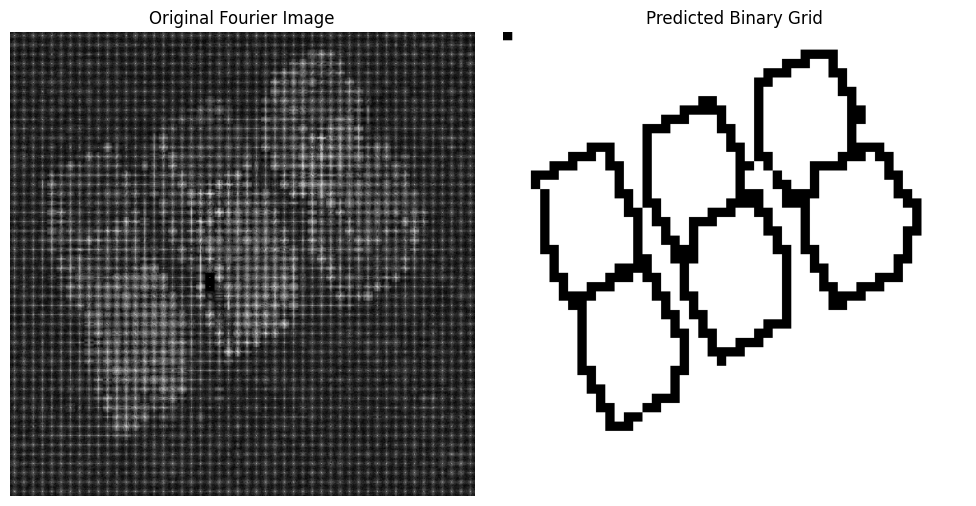

1/1 [==============================] - 0s 21ms/step


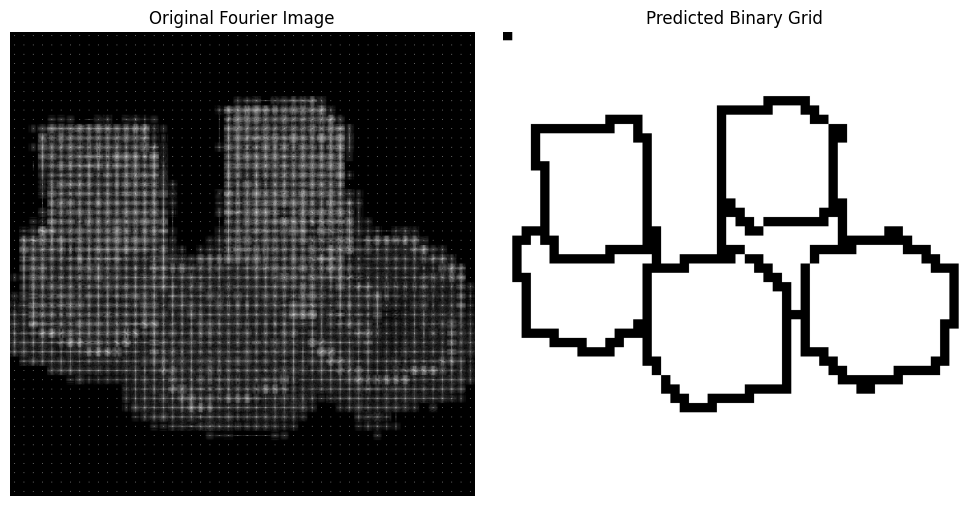

1/1 [==============================] - 0s 20ms/step


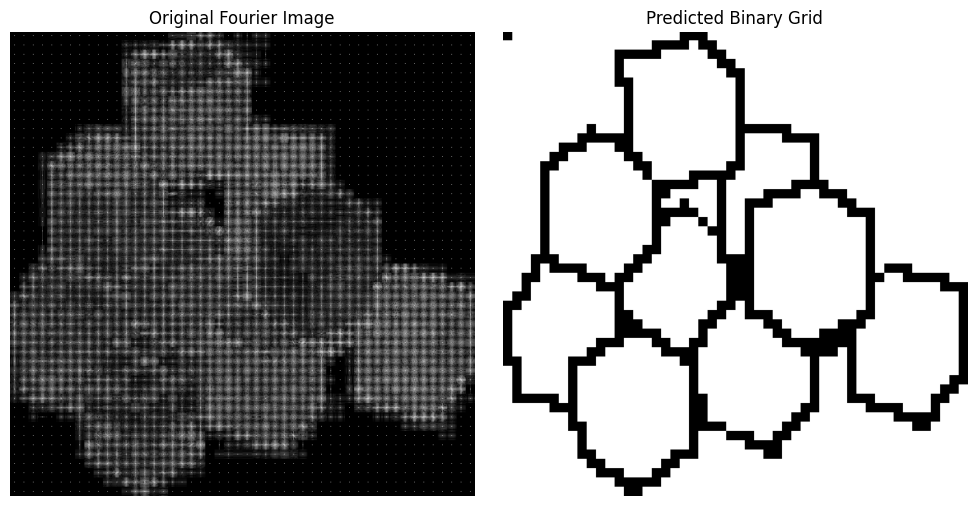

1/1 [==============================] - 0s 21ms/step


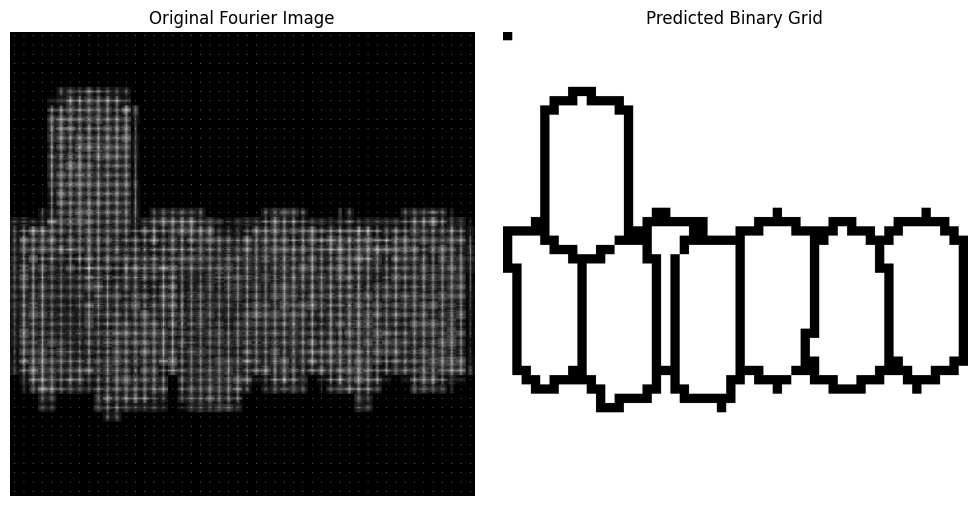

In [6]:
num_images_to_process = 4
cell_size = 15 # we divide the image (750x750) into 50x50, so grid cell size is 750 / 50 = 15
'''
We make black and white 1D images (binary images) of size same as the original image size,
but the difference is wherever we predict an edge (from the model) the intensity is 0, and rest all non edge parts are 255
'''
binary_images = [] # list to store the binary images
for images, labels in fourier_dataset.take(num_images_to_process): # iterate through the fourier dataset to predict edges from the model
    for image in images: # since we take a batch of images, we individually iterate through each image of the batch
        image = image.numpy() # convert image to numpy array

        # tensorflow needs a batch dimension to predict the label with the image, so we add a batch dimension
        if image.ndim == 3:
            image = image[None, ...]
            
        predicted_label = model.predict(image) # predict the label
        
        rows = image.shape[1] # number of rows in the image (in this case it is 750)
        cols = image.shape[2] # number of cols in the image (in this case it is 750)
        blank_slate = np.array([[255] * cols for _ in range(rows)]) # make an empty slate array which is the exact same size as the original image,
                                                                    # but 1D (in terms of number of channesl)
                                                                    # and only contains 255 as values in each [row, col]
        predicted_label = predicted_label[0] # label has a batch dimension, so remove the batch dimension
        '''
        predicted label has shape 50x50 (1D Array in terms of channels). We have to map the 50x50 label to 750x750 image
        '''
        for i in range(predicted_label.shape[0]):
            for j in range(predicted_label.shape[1]):
                if predicted_label[i][j] > 0.5: # if model detects an edge at the grid cell i, j
                    # make mapping parameters that map the coordinates from 50x50 to 750x750
                    row_low = i * cell_size
                    row_high = row_low + cell_size
                    col_low = j * cell_size
                    col_high = col_low + cell_size
                    blank_slate[row_low:row_high, col_low:col_high] = 0 # set the mapped gridcell to 0
        filled_slate = blank_slate # our blank slate is filled with edge information now so lets change the name

        '''
        plot the fourier image and filled slate image next to eachother
        '''
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # display fourier image
        axes[0].imshow(image[0])
        axes[0].set_title("Original Fourier Image")
        axes[0].axis('off')
        
        # display blank slate
        axes[1].imshow(blank_slate, cmap='gray')
        axes[1].set_title("Predicted Binary Grid")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

        binary_images.append(filled_slate) # append our filled slate to binary_images list
        
binary_images = np.array(binary_images) # convert our list to an np array for fun

In [7]:
'''
cell that takes each colour image from the dataset and appends them to a list
'''

colour_images = []
for images in colour_dataset.take(num_images_to_process):
    for image in images:
        colour_images.append(image.numpy())
colour_images = np.array(colour_images) # convert list to np array for fun

C:\Users\agile\AppData\Local\Temp\ipykernel_16892\661719641.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', total_components_found)  # pick a colormap with enough colors


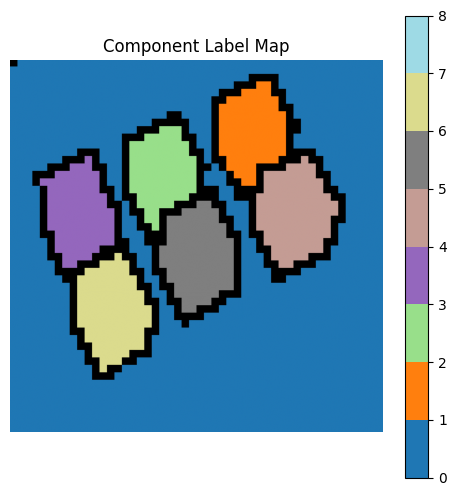

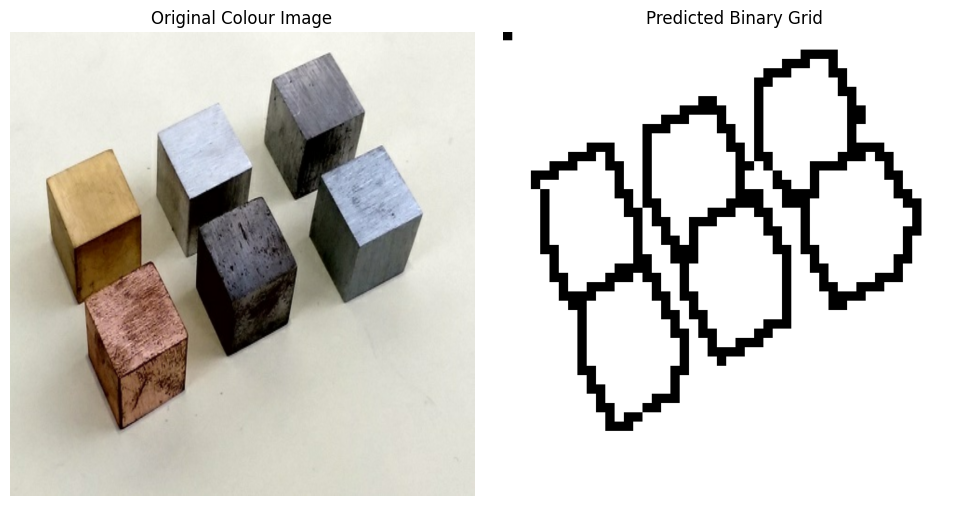

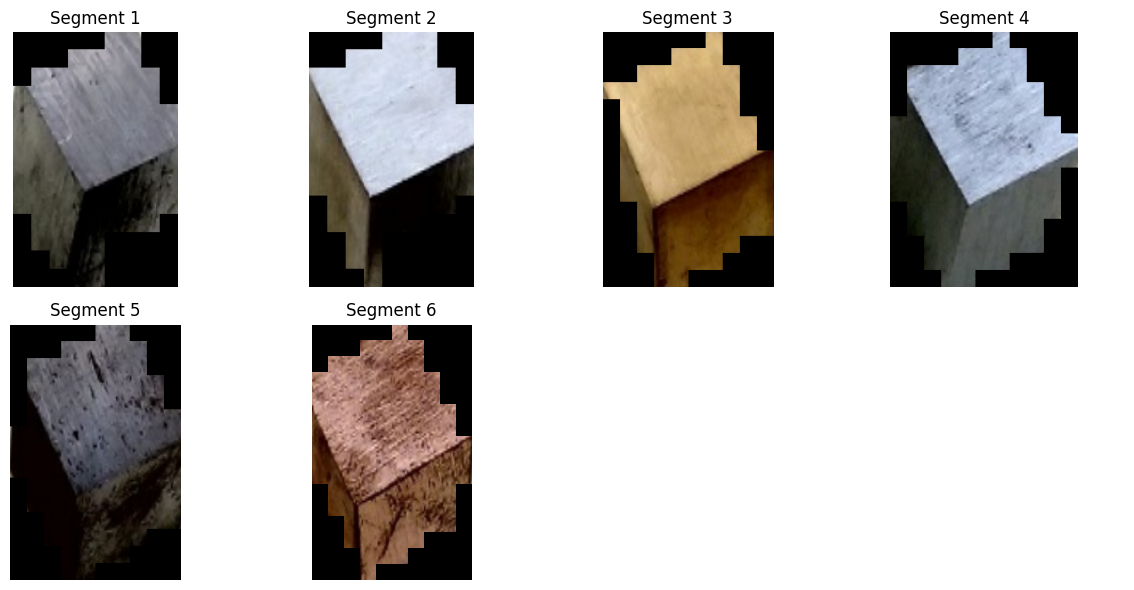

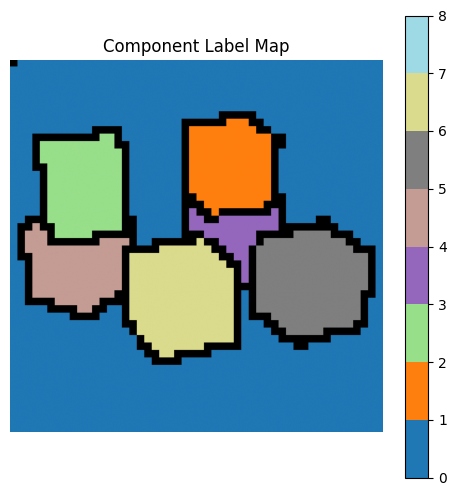

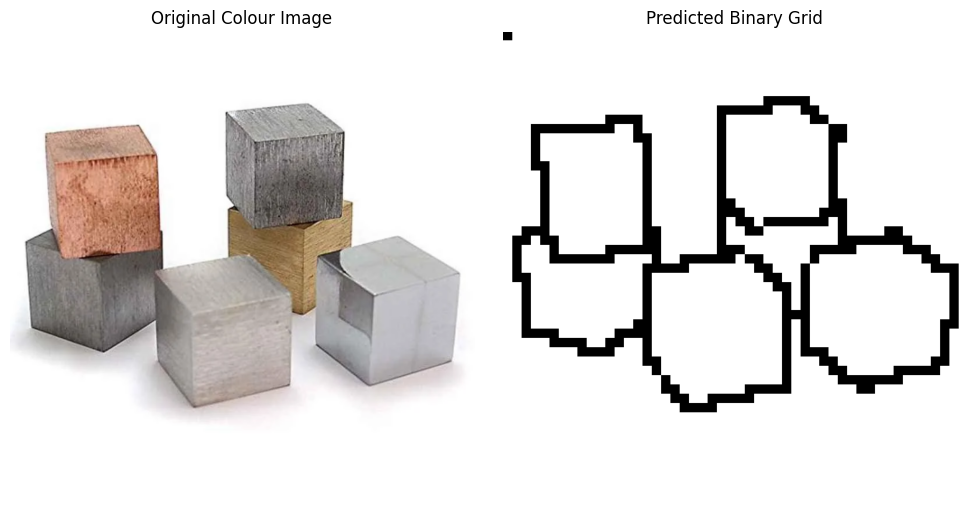

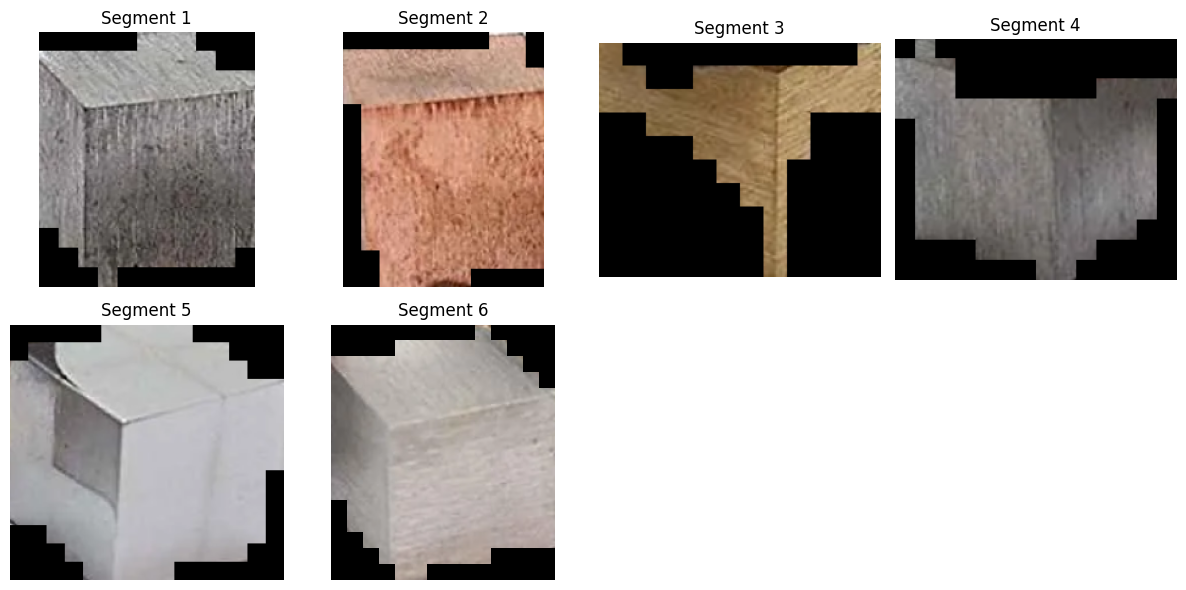

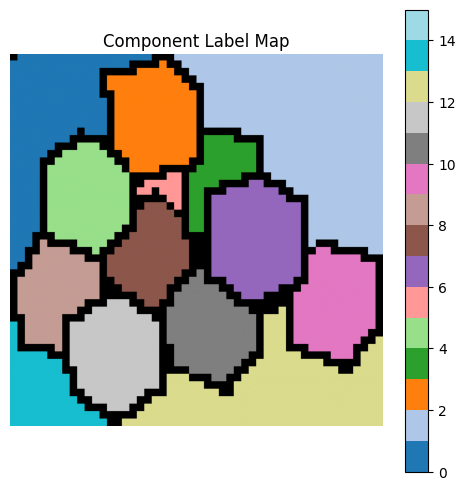

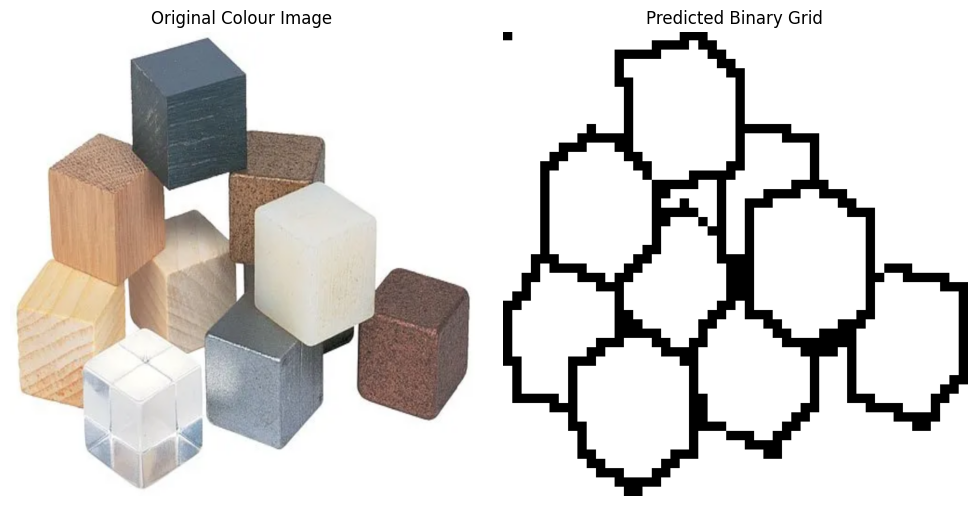

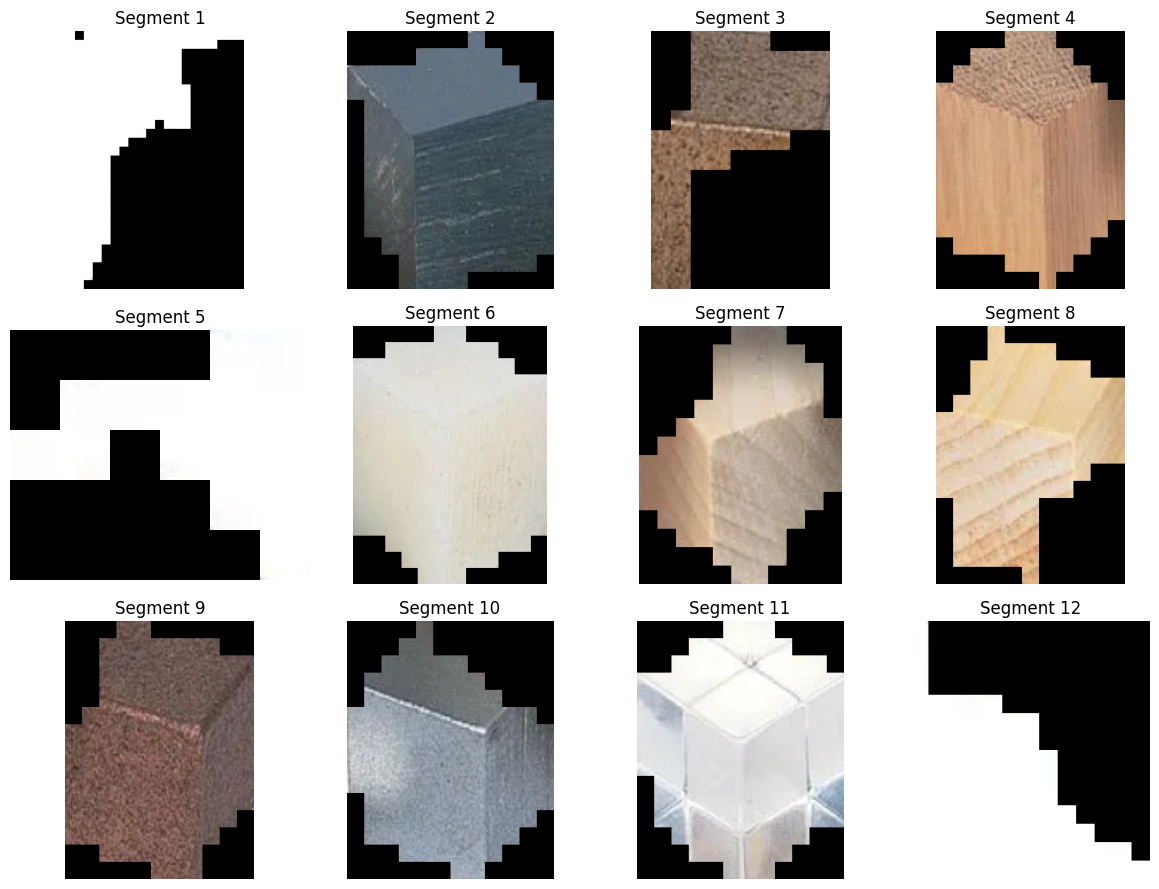

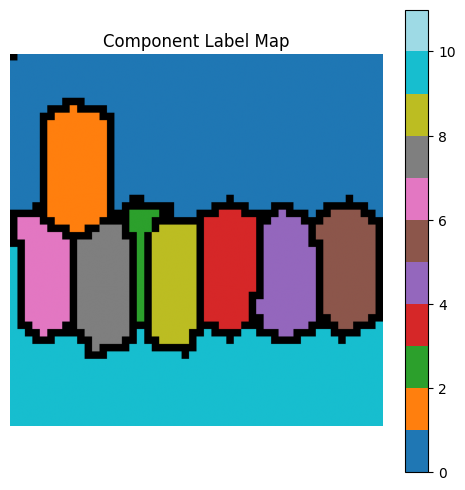

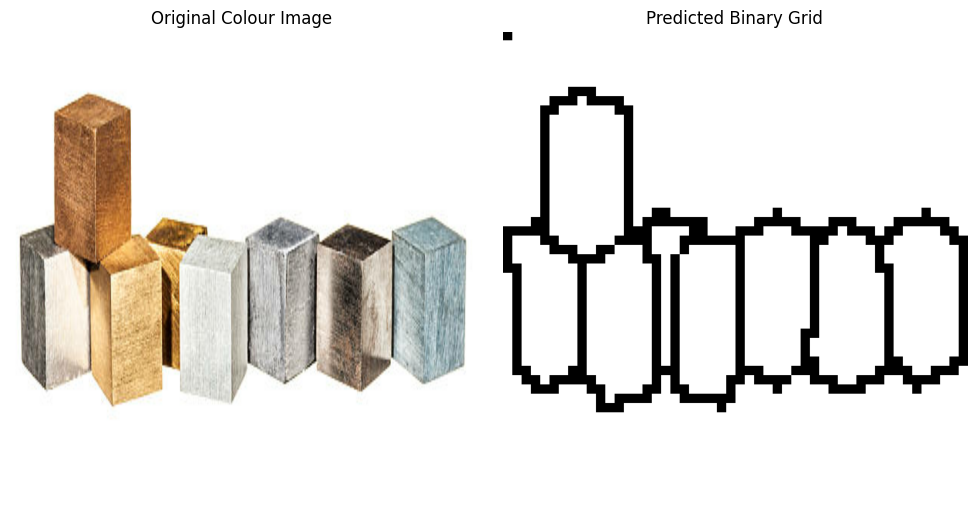

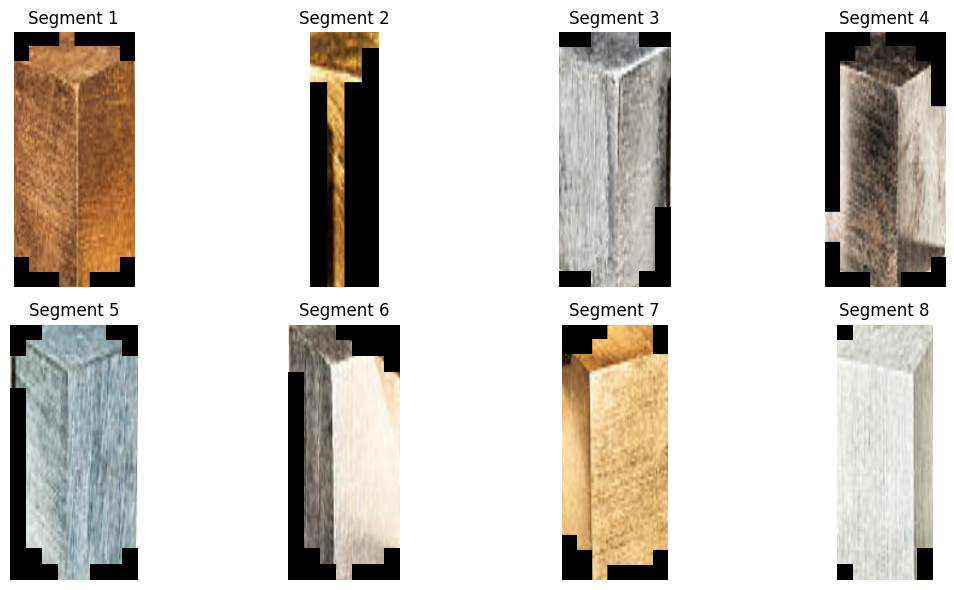

In [8]:

# these thresholds define how many pixels should a component have if we need it to be segmented
AREA_LOWER_THRESHOLD = 50
AREA_UPPER_THRESHOLD = 50000

# iterate through each binary image
for i, binary_image in enumerate(binary_images):
    # do connected components on the binary image
    total_components_found, component_labels_map, all_component_stats, all_component_centroids = custom_connected_components_dfs(binary_image_input=binary_image)
    
    # plot the connected component image returned by the function, giving a different colour for each component
    # idk how to do this plotting shit i got it from chatgpt
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.cm.get_cmap('tab20', total_components_found)  # pick a colormap with enough colors
    cmap.set_under('black')  # value 0 will be black
    im = ax.imshow(component_labels_map, cmap=cmap, vmin=0.5, vmax=total_components_found)
    ax.axis('off')
    ax.set_title('Component Label Map')
    plt.colorbar(im, ax=ax, boundaries=np.arange(0, total_components_found+1))
    plt.show()

    # take the corresponding colour image of the fourier image
    colour_image = colour_images[i]

    # plot the colour image and binary image so we can see what's going on
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(colour_image)
    axes[0].set_title("Original Colour Image")
    axes[0].axis('off')

    axes[1].imshow(binary_image, cmap='gray')
    axes[1].set_title("Predicted Binary Grid")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

    # now we go ahead and segment the components into images
    ith_segmented_colour_images = []
    for label, component_stat in enumerate(all_component_stats):
        area = component_stat[4] # get the area stat
        if area > AREA_LOWER_THRESHOLD and area < AREA_UPPER_THRESHOLD: # if area is within threshold, then we continue
            min_col = component_stat[0] # left most x coordinate of the component
            min_row = component_stat[1] # top most y coordinate of the component
            width = component_stat[2] # width of the component
            height = component_stat[3] # height of the component
        
            segmented_image = colour_image[min_row: min_row + height, min_col: min_col + width] # segment the image

            # if there exists pixels from other components in the segment, we would like them to be black in colour
            # so apply a mask to remove pixels from other components leaking into this one by setting values of those pixels to 0
            # if you didn't know label represents the component id, declared at the loop declaration
            component_mask = (component_labels_map[min_row:min_row + height, min_col:min_col + width] == label)
            component_mask = component_mask[..., None]  # Add channel dim: (H, W, 1)
            segmented_image = segmented_image * component_mask  # Broadcasts mask to RGB
            
            ith_segmented_colour_images.append(segmented_image) # append the segmented image into the segmented colour images list
            
    # display all segmented color images for the current i
    num_segments = len(ith_segmented_colour_images)
    
    if num_segments > 0:
        # decide grid layout — e.g. a single row or try a square layout
        cols = min(num_segments, 4)  # max 4 columns
        rows = int(np.ceil(num_segments / cols))
    
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
        # make axes a flat array for easy indexing
        axes = axes.flatten() if num_segments > 1 else [axes]
    
        for idx, seg_image in enumerate(ith_segmented_colour_images):
            axes[idx].imshow(seg_image)
            axes[idx].axis('off')
            axes[idx].set_title(f"Segment {idx+1}")
    
        for j in range(num_segments, len(axes)):
            axes[j].axis('off')
    
        plt.tight_layout()
        plt.savefig(f"{i + 1}th image's segmented images")
        plt.show()
            